这篇文章通过 手写数字识别 来讨论分类问题

In [74]:
# 准备工作
#准备工作

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# 忽略警告
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='internal')

# 图片存储目录
PROJECT_ROOT_DIR = '../'
CHAPTER_ID = 'classifiction'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("保存图片:", fig_id)
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### MNIST 数据集


作为机器学习的hello world 项目，每当有新的机器学习算法时，该数据集就会被用于评估该模型的性能。

In [75]:
from sklearn.datasets import fetch_mldata 
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

如上方法通过 函数从网络上下载数据集，默认保存在 ` $HOME/scikit_learn_data.`目录。  
通过sklearn 下载的数据都有以下结构：  
1. DESCR：数据集的描述
2. data： 数据集的数据，每行是一个实例， 每列是一个特征。
3. target: 数据集的标签，即需要预测的值。

In [76]:
X, y = mnist["data"], mnist["target"]

In [77]:
X.shape

(70000, 784)

In [78]:
y.shape

(70000,)

如上，包含该70000张图片，每张图片有28 * 28 个像素，共计784个特征。   
可以对每张图片进行可视化。

保存图片: some_digit_plot


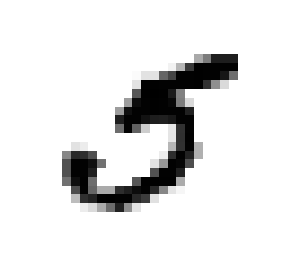

In [79]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

In [80]:
y[36000] #可以看到图片和标签都为5.

5.0

In [81]:
# 定义一个函数来查看图片
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

保存图片: more_digits_plot


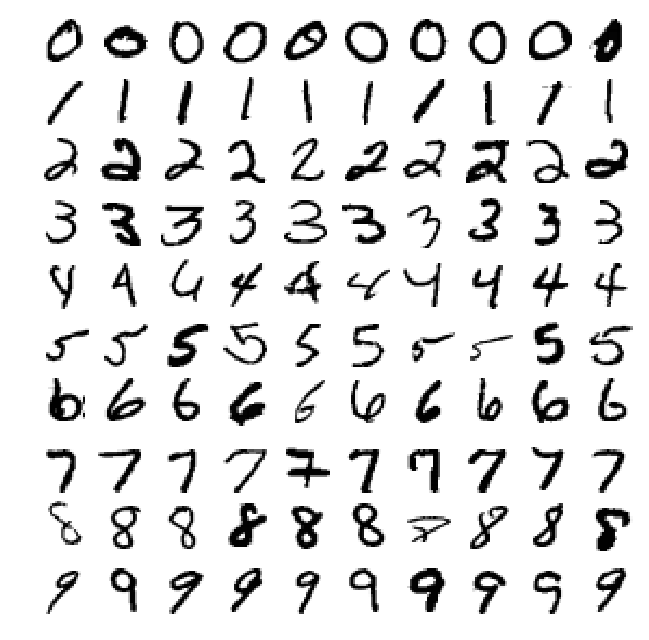

In [82]:
# 查看更多图片， 10 * 10
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:30600:600],  X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [83]:
# 切分测试集用于后续预测
X_train, y_train, X_test, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [84]:
# 由于该训练集对于顺序没有要求，不像股票数据或者天气数据。不是一般性，将其随机打乱
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y[shuffle_index]

### 训练一个二元分类器

从一个简单的为开始识别手写数字。首先判断一个实例是否为5.  
目标向量：

In [85]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

array([False, False,  True, ..., False, False,  True])

现在可以找一个分类器对其训练。从 随机梯度下降分类器开始，优点在神将网络中也有提到，能快速处理大的数据集, 非常适合在线学习。

In [86]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])  # 可以看到对图片 5 预测正确， 返回true。

array([ True])

### 评估性能

评估分类模型的精确度要比回归模型复杂的多。下面使用交叉验证来对该模型进行评估：

In [87]:
# 交叉验证， 为了保证随机抽样，可以自定义交叉验证方法，进行随机抽样。
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9652, 0.9679, 0.9516])

In [122]:
# 进行随机抽样，交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))
    

0.9569
0.96585
0.96405


In [89]:
# 看起来精确度还不错，下面定义一个最简单的分类器：
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) #永远返回0， 即预测等于5失败。

In [123]:
# 猜一下精确度
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.913  , 0.90655, 0.9094 ])

上述结果也有90的精确度，因为对于本次训练来说，不是5的比率在90%， 因此无论怎么训练，精确度最低都在90%。  
这说明了为什么精度通常不是用于分类器的首选性能度量， 特别是在某些类出现的比较频繁时。

### Confusion Matrix : 混淆矩阵

In [125]:
# 使用cross_val_predict
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred.shape

(60000,)

该函数与cross_val_score()类似，不过结果不是交叉验证的分数，而是每个测试fold的预测值。
这意味着可以得到一个 “清晰” 的预测值， 即该值所对应的实例不参与训练。

In [92]:
# 得到混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53894,   685],
       [ 1630,  3791]])

得到如上混淆矩阵：每行代表真实值，每列代表预测值。
比如第一行表示 为非5(nagative class)的图像数， 其中52849张( true nagative) 预测分类正确；1730张(false nagative) 图片预测失败。
第二行表示 为5(positive class) 的图像数，843预测失败，4587张测成功，共计60000张图片。

最理想的模型计算得到的混淆只包括 true positives 和 true negatives 两项。


In [93]:
confusion_matrix(y_train_5, y_train_5) #假设y_train_5就是预测值。

array([[54579,     0],
       [    0,  5421]])

混淆矩阵包含太多可用的信息。可以使用以下方法衡量分类器的准确度。  
precision = TP / (TP + FP)

这里存在一个问题。假设训练集中只有单一的正确值(5的图片只有一张)， 那么预测正确的话，精确度就是100%。
但是模型一般会忽略正确值而预测错误，因此这种精确度 不是非常有用。  
因此经常需要结合 recall 这种衡量方法， 也叫做 sensitivisy 和 true positive rate。  
计算方法为  recall = TP / (TP + FN), 通常表示预测正确的占比。  

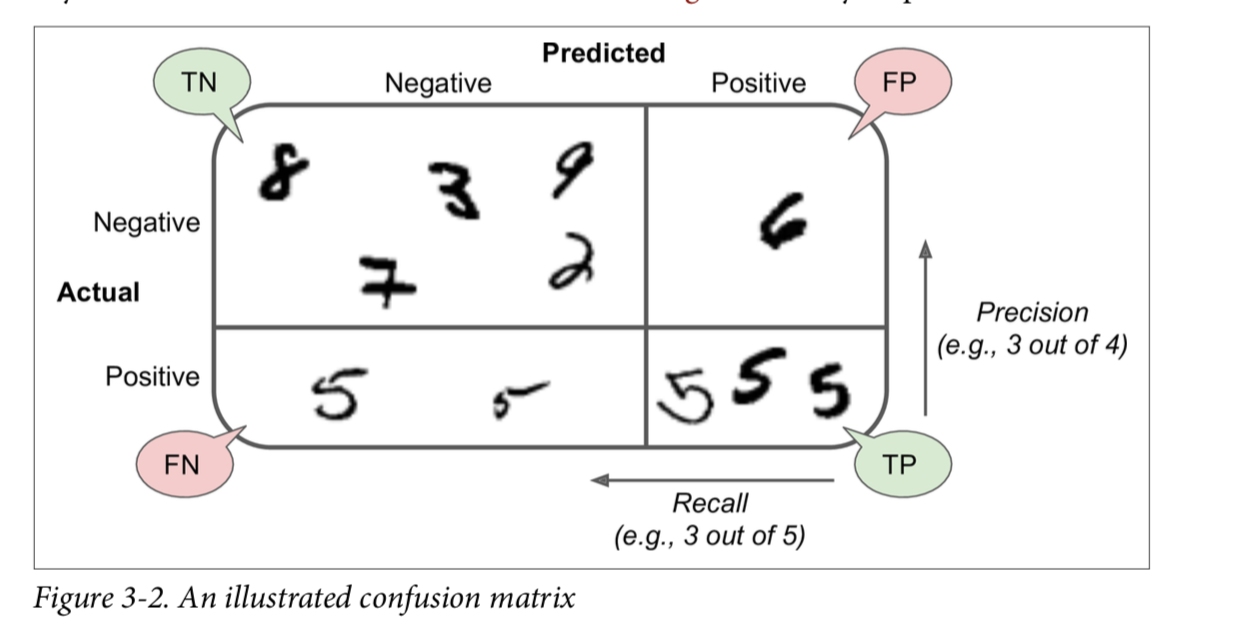

In [94]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 4587 / (4587 + 1730)

0.8469615728328865

In [95]:
recall_score(y_train_5, y_train_pred) # 4587 / (4587 + 834)

0.6993174691016417

以上结果相比之前的度量方法有不同。  
比如只有84%的精确度，并且只识别出了68%的正确图片5.

recall 越高，说明模型对正样本的识别能力越强，precision 体现了模型对负样本的区分能力，precision越高，说明模型对负样本的区分能力越强。  
F1-score 是两者的综合。F1-score 越高，说明分类模型越稳健。

更方便的，可以将精确度和召回率 组合为一个度量方法， 称为F1 分数，可以理解为两个度量的调和平均值。  
F1可以用于不同分类器的比较。  
此计算方法会加重 较小值的权重，因此在精确度和recall 都很高且接近的时候，才可以较高的F1分数。
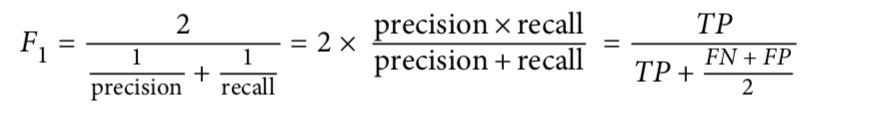

In [96]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.76609073456603

F1评分倾向于具有相似精度和召回率的分类器。但是某个情况比较在意精确度，某些情况比较在意recall。  
但是不可能增加精确度的同时减少recall， 这称为 `precision/recall tradeoff`

#### 精确度/召回率 权衡

可以这样理解：对于二分类问题，当精确度超过某一阈值， 可认为属于该类，否则就是相反类。
如下图所示比较清晰明显。
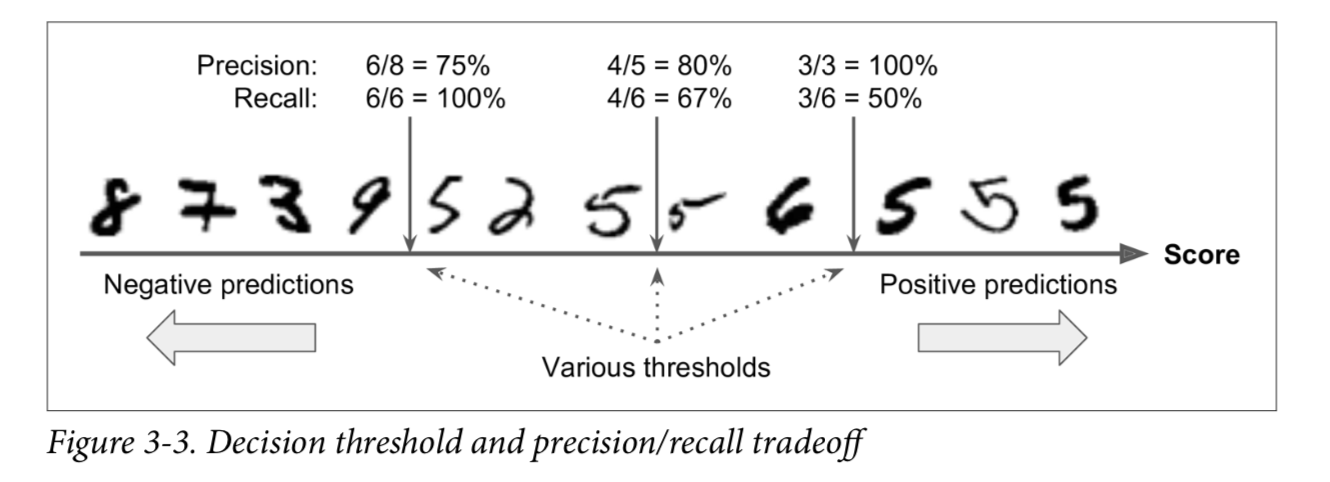

可以看到不同的阈值对precision/recall的影响。很明显，低阈值会增加召回率，降低精确度。

In [126]:
y_scores = sgd_clf.decision_function([some_digit])

y_scores

array([73778.26314291])

这里`decision_function()`返回每个实例对应的值， 可以设定阈值预测是不是图片5.
如下：

In [127]:
# 使用阈值来决定不同precision/recall
# 
threshold = 0 # 较小阈值
y_some_digit_pred = (y_scores > threshold)


In [128]:
y_some_digit_pred  # 与阈值比较

array([ True])

In [100]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

问题就变成怎么选择一个合适的阈值：

In [101]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [129]:
y_scores

array([73778.26314291])

In [103]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [104]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=15)
    plt.ylim([0, 1])

保存图片: precision_recall_vs_thresold_plot


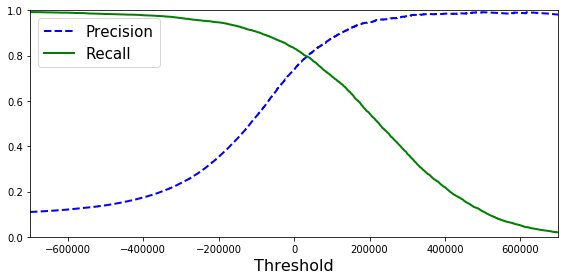

In [105]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_thresold_plot")
plt.show()

从上图 可以看出，随着阈值的调整，精度度和召回率也在变化，目标就是找到一个最合适的值。

In [106]:
(y_train_pred == (y_scores > 0)).all()

False

In [107]:
(y_train_pred == (y_scores > 70000)).all()

False

In [108]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.8423013245033113

In [109]:
recall_score(y_train_5, y_train_pred_90)

0.7507839881940601

In [110]:
def plot_precision_vs_recall(precisions, recalls):
    
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

保存图片: precision_vs_recall_plot


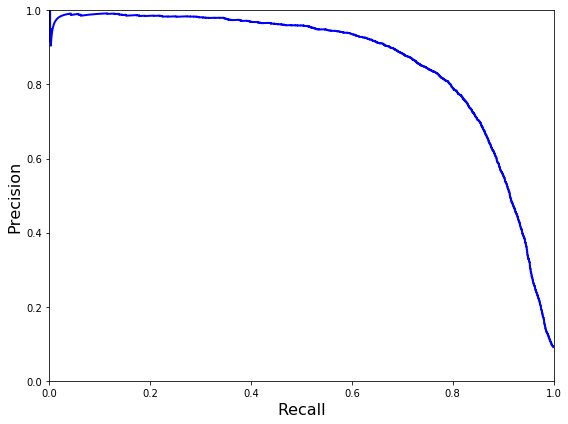

In [111]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

### ROC 曲线
针对二分类问题的另一种工具。

In [112]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [113]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

保存图片: roc_curve_plot


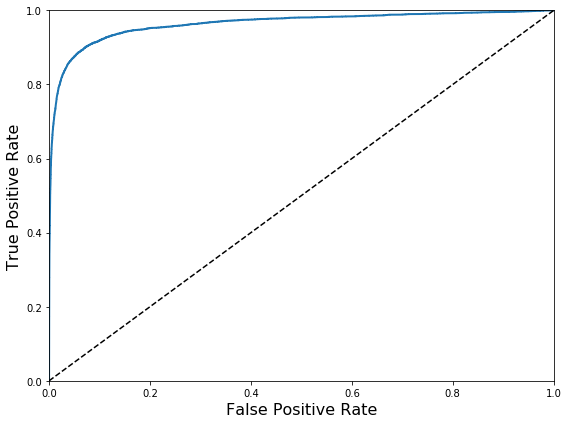

In [114]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [115]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9635471375044704

In [116]:
# 使用随机森林分类器
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,  method="predict_proba")

In [117]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

保存图片: roc_curve_comparison_plot


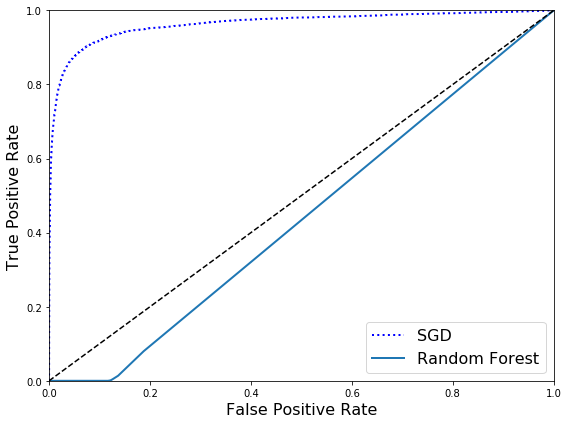

In [118]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [119]:
roc_auc_score(y_train_5, y_scores_forest)

0.44120313387823584

In [120]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9842381786339754

In [121]:
recall_score(y_train_5, y_train_pred_forest)

0.8293672754104409

### 多分类